In [1]:
# Imports
import pretty_midi
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import reverse_pianoroll
import IPython.display as ipd

In [2]:
DATA_PATH = 'data/clean_midi/"Weird Al" Yankovic/'
midi_path = DATA_PATH + 'Headline News.mid'
mp3_path = DATA_PATH + 'headline_news.mp3'
pm = pretty_midi.PrettyMIDI(midi_path)

ipd.Audio(mp3_path)

/Users/faraaz/anaconda3/envs/urop/lib/python3.6/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


In [3]:
# get piano roll from midi
fs = 10
duration = 5
frames = fs * duration
piano_roll = pm.get_piano_roll(fs=fs, times=np.arange(0, duration, 1./fs))
print(len(pm.get_onsets()))

3943


In [4]:
# process piano roll to make it monophonic
highest_notes = np.transpose(np.zeros(np.shape(piano_roll)))
highest_notes[np.arange(frames)] = np.arange(1, 129)
highest_notes = np.transpose(highest_notes)
highest_notes[piano_roll == 0] = 0
highest_notes = highest_notes.argmax(axis=0)
mono_piano_roll = np.zeros(np.shape(piano_roll))
mono_piano_roll[highest_notes, np.arange(frames)] = 90
mono_piano_roll[0, :] = 0

# get midi from monophonic piano roll
mono_midi = reverse_pianoroll.piano_roll_to_pretty_midi(mono_piano_roll, fs=fs)
mono_midi.write("mono.midi")
print(len(mono_midi.get_onsets()))

13


In [5]:
# convert monophonic midi to audio
sr = 22050
hop_length = 512
mono_audio = mono_midi.fluidsynth(fs=sr)
print("mono audio shape: {}".format(np.shape(mono_audio)))
ipd.Audio(mono_audio, rate=sr)

mono audio shape: (130096,)


C shape: (84, 255)


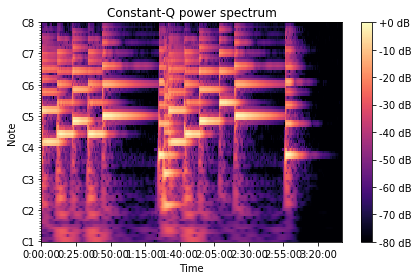

In [15]:
# get spectrogram from audio
C = np.abs(librosa.cqt(mono_audio, sr=sr, hop_length=hop_length, n_bins=84))
print("C shape: {}".format(C.shape))
librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                         sr=fs, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrum')
plt.tight_layout()

In [7]:
# get piano roll from spectrogram
reconstructed_piano_roll = reverse_pianoroll.cqt_to_piano_roll(C, 24, 108, 80)
print(reconstructed_piano_roll.shape)

(128, 255)


In [8]:
# get midi from piano roll
feature_rate = sr / hop_length
reconstructed_midi = reverse_pianoroll.piano_roll_to_pretty_midi(reconstructed_piano_roll, fs=feature_rate)

In [10]:
# convert midi to audio
reconstructed_audio = reconstructed_midi.fluidsynth(fs=sr)
print("reconstructed audio shape: {}".format(np.shape(reconstructed_audio)))
print(reconstructed_midi.get_onsets())
ipd.Audio(reconstructed_audio, rate=sr)

reconstructed audio shape: (130594,)
[0.34829932 0.62693878 0.95201814 1.2306576  2.32199546 2.43809524
 2.83283447 3.13469388 3.52943311 3.62231293 3.83129252 4.82975057]
